In [ ]:
# !conda install -c conda-forge black
# !pip install nb_black
# !conda install -c conda-forge jupyterlab_code_formatter
# %load_ext nb_black

In [98]:
# coding: utf-8
from __future__ import division, absolute_import
from __future__ import print_function, unicode_literals

import numpy as np, seaborn as sns, matplotlib.pyplot as plt, random
from pathlib import Path
import gym, lake_envs as lake_env


def print_policy(policy, action_names):
    """Print the policy in human-readable format.

    Parameters
    ----------
    policy: np.ndarray
      Array of state to action number mappings
    action_names: dict
      Mapping of action numbers to characters representing the action.
    """
    str_policy = policy.astype('str')
    for action_num, action_name in action_names.items():
        np.place(str_policy, policy == action_num, action_name)
    print(str_policy)



######################
#  Optional Helpers  #
######################

# Here we provide some helper functions simply for your convinience.
# You DON'T necessarily need them, especially "env_wrapper" if
# you want to deal with it in your different ways.

# Feel FREE to change/delete these helper functions.

def display_policy_letters(env, policy):
    """Displays a policy as letters, as required by problem 1.2 & 1.3

    Parameters
    ----------
    env: gym.core.Environment
    policy: np.ndarray, with shape (env.nS)
    """
    policy_letters = []
    for l in policy:
        policy_letters.append(lake_env.action_names[l][0])

    policy_letters = np.array(policy_letters).reshape(env.nrow, env.ncol)


    for row in range(env.nrow):
        print(''.join(policy_letters[row, :]))
    # Return an array 
    return policy_letters

def env_wrapper(env_name):
    """Create a convinent wrapper for the loaded environment

    Parameters
    ----------
    env: gym.core.Environment

    Usage e.g.:
    ----------
        envd4 = env_load('Deterministic-4x4-FrozenLake-v0')
        envd8 = env_load('Deterministic-8x8-FrozenLake-v0')
    """
    env = gym.make(env_name)

    # T : the transition probability from s to s’ via action a
    # R : the reward you get when moving from s to s' via action a
    env.T = np.zeros((env.nS, env.nA, env.nS))
    env.R = np.zeros((env.nS, env.nA, env.nS))

    for state in range(env.nS):
        for action in range(env.nA):
            for prob, nextstate, reward, is_terminal in env.P[state][action]:
                env.T[state, action, nextstate] = prob
                env.R[state, action, nextstate] = reward
    return env


def value_func_heatmap(env, value_func):
    """Visualize a policy as a heatmap, as required by problem 1.2 & 1.3

    Note that you might need:
        import matplotlib.pyplot as plt
        import seaborn as sns

    Parameters
    ----------
    env: gym.core.Environment
    value_func: np.ndarray, with shape (env.nS)
    """
    fig, ax = plt.subplots(figsize=(7,6))
    sns.heatmap(np.reshape(value_func, [env.nrow, env.ncol]),
                annot=False, linewidths=.5, cmap="GnBu_r", ax=ax,
                yticklabels = np.arange(1, env.nrow+1)[::-1],
                xticklabels = np.arange(1, env.nrow+1))
    # Other choices of cmap: YlGnBu
    # More: https://matplotlib.org/3.1.1/gallery/color/colormap_reference.html
    return fig

def write_answers(env, policy, env_name, policy_name, value_func, output_path=Path('./outputs')):
    output_path.mkdir(parents=True, exist_ok=True)
    value_map = value_func_heatmap(env, value_func)
    value_map.savefig(output_path/(env_name+'-'+policy_name+'.png'))
    policy_actions_arr = display_policy_letters(env, policy)
    np.savetxt(output_path/(env_name+'-'+policy_name+"_policy_letters.txt"), policy_actions_arr, fmt='%s')

Helper functions

In [86]:
def compute_Vs(env, V, s, a, gamma=0.9):
    ''' Cacluate V(s) given by the q(s,a) '''
    r_tot = 0
    for (p, s_next, r, _) in env.P[s][a]:
        r_tot += p * (r + gamma * V[s_next])
    return r_tot

def value_function_to_policy(env, gamma, value_function):
    """Output action numbers for each state in value_function.

    Parameters
    ----------
    env: gym.core.Environment
      Environment to compute policy for. Must have nS, nA, and P as
      attributes.
    gamma: float
      Discount factor. Number in range [0, 1)
    value_function: np.ndarray
      Value of each state.

    Returns
    -------
    np.ndarray
      An array of integers. Each integer is the optimal action to take
      in that state according to the environment dynamics and the
      given value function.
    """
    # Hint: You might want to first calculate Q value,
    #       and then take the argmax.
    pi = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        a_v = [compute_Vs(env, value_function, s, a, gamma=gamma) for a in range(env.nA)]
        pi[s] = np.argmax(a_v)
    return pi

Policy iterations

In [121]:
def evaluate_policy_sync(env, value_func, gamma, policy, max_iterations=int(1e3), tol=1e-3):
    """Performs policy evaluation.

    Evaluates the value of a given policy.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    value_func: np.array
      The current value functione estimate
    gamma: float
      Discount factor, must be in range [0, 1)
    policy: np.array
      The policy to evaluate. Maps states to actions.
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    np.ndarray, int
      The value for the given policy and the number of iterations till
      the value function converged.
    """
    
    n_eval_iter = 0
    print("Sync Policy evaluation")
    while True:
        delta = 0
        n_eval_iter+=1; print("Evluation iteration:", n_eval_iter)
        v_s_old = value_func.copy() # make a copy (synchronous require 2 distinct copy)
        for s in range(env.nS):
            value_func[s] = compute_Vs(env, V=v_s_old, s=s, a = policy[s], gamma=gamma)
            delta = max(delta, np.abs(value_func[s] - v_s_old[s]))
        if delta < tol or n_eval_iter==max_iterations: 
            return value_func, n_eval_iter

def evaluate_policy_async_ordered(env, value_func, gamma, policy, max_iterations=int(1e3), tol=1e-3):
    """Performs policy evaluation.

    Evaluates the value of a given policy by asynchronous DP.  Updates states in
    their 1-N order.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    value_func: np.array
      The current value functione estimate
    gamma: float
      Discount factor, must be in range [0, 1)
    policy: np.array
      The policy to evaluate. Maps states to actions.
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    np.ndarray, int
      The value for the given policy and the number of iterations till
      the value function converged.
    """
    
    n_eval_iter = 0
    while True:
        delta = 0
        n_eval_iter+=1; print("Evluation iteration:", n_eval_iter)
        for s in range(env.nS):
            old_v = value_func[s]
            value_func[s] = compute_Vs(env, V=value_func, s=s, a=policy[s], gamma=gamma)   # use old value function
            delta = max(delta, np.abs(value_func[s] - old_v))
        print("Iteration delta:", delta)
        if delta < tol: return value_func, n_eval_iter
        if n_eval_iter >= max_iterations: return value_func, n_eval_iter

def evaluate_policy_async_randperm(env, value_func, gamma, policy, max_iterations=int(1e3), tol=1e-3):
    """Performs policy evaluation.

    Evaluates the value of a policy.  Updates states by randomly sampling index
    order permutations.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    value_func: np.array
      The current value functione estimate
    gamma: float
      Discount factor, must be in range [0, 1)
    policy: np.array
      The policy to evaluate. Maps states to actions.
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    np.ndarray, int
      The value for the given policy and the number of iterations till
      the value function converged.
    """
    n_eval_iter = 0
    while True:
        n_eval_iter+=1; print("Evluation iteration:", n_eval_iter)
        delta = 0
        for s in random.sample(range(env.nS), env.nS):
            v_old = value_func[s]
            value_func[s] = compute_Vs(env, value_func, s, a=policy[s], gamma=gamma)
            delta = max(delta, np.abs(value_func[s] - v_old))
        if delta < tol: return value_func, n_eval_iter 
        if n_eval_iter >= max_iterations: return value_func, n_eval_iter

def improve_policy(env, value_func, policy, gamma=0.9):
    """Performs policy improvement.

    Given a policy and value function, improves the policy.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    value_func: np.ndarray
      Value function for the given policy.
    policy: dict or np.array
      The policy to improve. Maps states to actions.

    Returns
    -------
    bool, np.ndarray
      Returns true if policy changed. Also returns the new policy.
    """
    print("Improve Policy")
    policy_stable=False
    old_policy = policy.copy()
    for s in range(env.nS): # iterate for each state
        a_r = [compute_Vs(env, value_func, s, a, gamma) for a in range(env.nA)] # action reward
        policy[s] = np.argwhere(a_r==np.max(a_r)).flatten()[0]
    if np.all(policy == old_policy): policy_stable = True
    #print(policy, old_policy)
    return policy_stable, policy


def policy_iteration_sync(env, gamma=0.9, max_iterations=int(1e3), tol=1e-3):
    """Runs policy iteration.

    See page 85 of the Sutton & Barto Second Edition book.

    You should use the improve_policy() and evaluate_policy_sync() methods to
    implement this method.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    (np.ndarray, np.ndarray, int, int)
       Returns optimal policy, value function, number of policy
       improvement iterations, and number of value iterations.
    """
    value_func = np.random.uniform(low=0, high=0, size=env.nS)
    pi = np.zeros(env.nS, dtype=int)
    stable=False
    n_eval_iter = n_iter = 0
    while not stable:
        n_iter += 1; print("Iteration number:", n_iter)
        value_func, eval_iters = evaluate_policy_sync(env, value_func, gamma, pi,max_iterations, tol)
        stable, pi = improve_policy(env, value_func, pi, gamma)
        n_eval_iter += eval_iters
    return pi, value_func, n_iter, n_eval_iter


def policy_iteration_async_ordered(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """Runs policy iteration.

    You should use the improve_policy and evaluate_policy_async_ordered methods
    to implement this method.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    (np.ndarray, np.ndarray, int, int)
       Returns optimal policy, value function, number of policy
       improvement iterations, and number of value iterations.
    """
    value_func = np.random.uniform(low=0, high=0, size=env.nS)
    pi = np.zeros(env.nS, dtype=int)
    stable=False
    n_eval_iter = n_iter = 0
    while not stable:
        n_iter += 1; print("Iteration number:", n_iter)
        value_func, eval_iters = evaluate_policy_async_ordered(env, value_func, gamma, pi,max_iterations, tol)
        stable, pi = improve_policy(env, value_func, pi, gamma)
        n_eval_iter += eval_iters
    return pi, value_func, n_iter, n_eval_iter


def policy_iteration_async_randperm(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """Runs policy iteration.

    You should use the improve_policy and evaluate_policy_async_randperm methods
    to implement this method.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    (np.ndarray, np.ndarray, int, int)
       Returns optimal policy, value function, number of policy
       improvement iterations, and number of value iterations.
    """
    value_func = np.random.uniform(low=0, high=0, size=env.nS)
    pi = np.zeros(env.nS, dtype=int)
    stable=False
    n_val_iter = n_iter = 0
    while not stable:
        n_iter += 1; print("Iteration number:", n_iter)
        value_func, eval_iters = evaluate_policy_async_randperm(env, value_func, gamma, pi,max_iterations, tol)
        stable, pi = improve_policy(env, value_func, pi, gamma)
        n_val_iter += eval_iters
    return pi, value_func, n_iter, n_val_iter

Policy iteration
Iteration number: 1
Evluation iteration: 1
Improve Policy
Iteration number: 2
Evluation iteration: 1
Evluation iteration: 2
Improve Policy
Iteration number: 3
Evluation iteration: 1
Evluation iteration: 2
Improve Policy
Iteration number: 4
Evluation iteration: 1
Evluation iteration: 2
Evluation iteration: 3
Evluation iteration: 4
Evluation iteration: 5
Improve Policy
Iteration number: 5
Evluation iteration: 1
Evluation iteration: 2
Improve Policy
Iteration number: 6
Evluation iteration: 1
Evluation iteration: 2
Improve Policy
Iteration number: 7
Evluation iteration: 1
Evluation iteration: 2
Improve Policy
Iteration number: 8
Evluation iteration: 1
Evluation iteration: 2
Improve Policy
Policy iteration
Iteration number: 1
Evluation iteration: 1
Improve Policy
Iteration number: 2
Evluation iteration: 1
Evluation iteration: 2
Improve Policy
Iteration number: 3
Evluation iteration: 1
Evluation iteration: 2
Improve Policy
Iteration number: 4
Evluation iteration: 1
Evluation

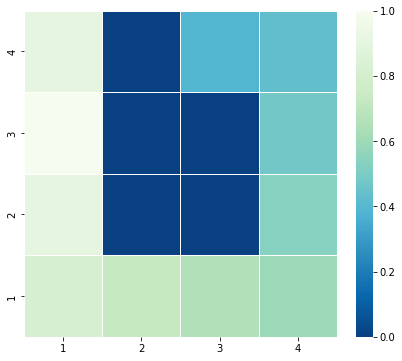

In [123]:
if __name__ == "__main__":
    envs = ['Deterministic-4x4-FrozenLake-v0', 'Deterministic-8x8-FrozenLake-v0']
    policy_iteration_types = {'policy_iteration_sync': policy_iteration_sync, 
                              'policy_iteration_async_ordered': policy_iteration_async_ordered,
                              'policy_iteration_async_randperm': policy_iteration_async_randperm}
    # Define num_trials, gamma and whatever variables you need below.
    env_num = 0
    policy_iter_type = 'policy_iteration_async_randperm'
    env = gym.make(envs[env_num])
 
    # Define num_trials, gamma and whatever variables you need below.
    max_trials = 1e3
    tol=1e-3
    gamma = .9
    n_trials = 10
    all_iters, all_eval_iters = [], []
    for i in range(n_trials):
        print("Policy iteration")
        policy, value_func, n_pi_iterations, n_eval_iteration = policy_iteration_types[policy_iter_type](env, gamma=gamma)
        all_iters.append(n_pi_iterations)
        all_eval_iters.append(n_eval_iteration)
    print(f"Took avg total iterations:{sum(all_iters)/n_trials}")
    print(f"Took avg evaluation iterations:{sum(all_eval_iters)/n_trials}")
    write_answers(env, policy, envs[env_num], policy_iter_type, value_func)
    #pi_ = value_function_to_policy(env, gamma, value_func)

<b>Value iterations

In [166]:
def value_iteration_sync(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """Runs value iteration for a given gamma and environment.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    np.ndarray, iteration
      The value function and the number of iterations it took to converge.
    """
    value_func = np.zeros(env.nS)  # initialize value function
    #value_func = np.random.uniform(low=0, high=0, size=env.nS)
    n_iter=0
    while True:
        n_iter+=1; print("Evluation iteration:", n_iter)
        delta = 0
        value_func_old = value_func.copy()
        for s in range(env.nS): # iterate for each state
            action_vals = [compute_Vs(env, value_func_old, s, a, gamma=gamma) for a in range(env.nA)]
            value_func[s] = np.max(action_vals)
            delta = max(delta, np.abs(value_func[s] - value_func_old[s]))
        if delta < tol: return value_func, n_iter
        if n_iter > max_iterations: return value_func, n_iter



def value_iteration_async_ordered(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """Runs value iteration for a given gamma and environment.
    Updates states in their 1-N order.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    np.ndarray, iteration
      The value function and the number of iterations it took to converge.
    """
    value_func = np.zeros(env.nS)  # initialize value function
    n_iter=0
    while True:
        n_iter+=1; print("Evluation iteration:", n_iter)
        delta = 0
        for s in range(env.nS): # iterate for each state
            old_val = value_func[s]
            value_func[s] = np.max([compute_Vs(env, value_func, s, a, gamma=gamma) for a in range(env.nA)])
            delta = max(delta, np.abs(value_func[s] - old_val))
        if delta < tol: return value_func, n_iter
        if n_iter > max_iterations: return value_func, n_iter
    return value_func, 0


def value_iteration_async_randperm(env, gamma, max_iterations=int(1e3), tol=1e-3):
    """Runs value iteration for a given gamma and environment.
    Updates states by randomly sampling index order permutations.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    np.ndarray, iteration
      The value function and the number of iterations it took to converge.
    """    
    value_func = np.zeros(env.nS)  # initialize value function
    n_iter=0
    while True:
        n_iter+=1; print("Evluation iteration:", n_iter)
        delta = 0
        for s in random.sample(range(env.nS), env.nS): # iterate for each state
            old_val = value_func[s]
            value_func[s] = np.max([compute_Vs(env, value_func, s, a, gamma=gamma) for a in range(env.nA)])
            delta = max(delta, np.abs(value_func[s] - old_val))
        if delta < tol: return value_func, n_iter
        if n_iter > max_iterations: return value_func, n_iter
    return value_func, 0


def value_iteration_async_custom(env, gamma, goal_coord, max_iterations=int(1e3), tol=1e-3):
    """Runs value iteration for a given gamma and environment.
    Updates states by student-defined heuristic.

    Parameters
    ----------
    env: gym.core.Environment
      The environment to compute value iteration for. Must have nS,
      nA, and P as attributes.
    gamma: float
      Discount factor, must be in range [0, 1)
    max_iterations: int
      The maximum number of iterations to run before stopping.
    tol: float
      Determines when value function has converged.

    Returns
    -------
    np.ndarray, iteration
      The value function and the number of iterations it took to converge.
    """
    def get_matrix_dist_from_pt(n, start_coord=(0,0)):
        """
        get distance matrix from a starting point
        """
        dist_mat = np.zeros((n,n))
        for i in range(n):
            for j in range(n):
                dist_mat[i][j] = np.sqrt((i-start_coord[0])**2+(j-start_coord[1])**2)
        return dist_mat

    value_func = np.zeros(env.nS)  # initialize value function
    dist_ordered_states = np.argsort(get_matrix_dist_from_pt(int(np.sqrt(env.nS)), start_coord=goal_coord).flatten())
    n_iter=0
    while True:
        n_iter+=1; print("Evluation iteration:", n_iter)
        delta = 0
        for s in dist_ordered_states: # iterate for each state
            old_val = value_func[s]
            value_func[s] = np.max([compute_Vs(env, value_func, s, a, gamma=gamma) for a in range(env.nA)])
            delta = max(delta, np.abs(value_func[s] - old_val))
        if delta < tol: return value_func, n_iter
        if n_iter > max_iterations: return value_func, n_iter
    return value_func, 0


Value iteration
Evluation iteration: 1
Evluation iteration: 2
Evluation iteration: 3
Evluation iteration: 4
Evluation iteration: 5
Evluation iteration: 6
Evluation iteration: 7
Value iteration
Evluation iteration: 1
Evluation iteration: 2
Evluation iteration: 3
Evluation iteration: 4
Evluation iteration: 5
Evluation iteration: 6
Evluation iteration: 7
Value iteration
Evluation iteration: 1
Evluation iteration: 2
Evluation iteration: 3
Evluation iteration: 4
Evluation iteration: 5
Evluation iteration: 6
Evluation iteration: 7
Value iteration
Evluation iteration: 1
Evluation iteration: 2
Evluation iteration: 3
Evluation iteration: 4
Evluation iteration: 5
Evluation iteration: 6
Evluation iteration: 7
Value iteration
Evluation iteration: 1
Evluation iteration: 2
Evluation iteration: 3
Evluation iteration: 4
Evluation iteration: 5
Evluation iteration: 6
Evluation iteration: 7
Value iteration
Evluation iteration: 1
Evluation iteration: 2
Evluation iteration: 3
Evluation iteration: 4
Evluati

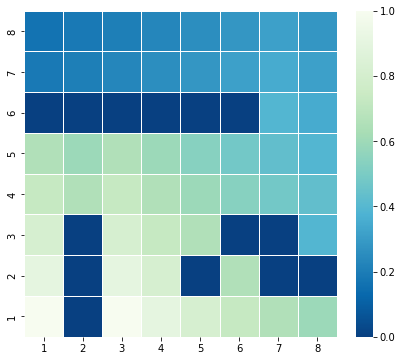

In [180]:
if __name__ == "__main__":
    envs = ['Deterministic-4x4-FrozenLake-v0', 'Deterministic-8x8-FrozenLake-v0']
    goal_coord = {
        'Deterministic-4x4-FrozenLake-v0': (1, 1),
        'Deterministic-8x8-FrozenLake-v0': (7, 1)
    }
    value_iteration_types = {
        'value_iteration_sync': value_iteration_sync, 
        'value_iteration_async_ordered': value_iteration_async_ordered,
        'value_iteration_async_randperm': value_iteration_async_randperm,
        'value_iteration_async_custom': value_iteration_async_custom
    }
    # Define num_trials, gamma and whatever variables you need below.
    env_num = 1
    value_iter_type = 'value_iteration_async_custom'
    env = gym.make(envs[env_num])
 
    # Define num_trials, gamma and whatever variables you need below.
    max_trials = 1e3
    tol=1e-3
    gamma = .9
    n_trials = 10
    all_iters = []
    for i in range(n_trials):
        print("Value iteration")
        if value_iter_type == 'value_iteration_async_custom':
            value_func, n_val_iter = value_iteration_types['value_iteration_async_custom'](
                env, gamma, goal_coord=goal_coord[envs[env_num]])
        else:
            value_func, n_val_iter = value_iteration_types[value_iter_type](env, gamma)
        pi = value_function_to_policy(env, gamma, value_func)
        all_iters.append(n_val_iter)
    print(f"Took avg total iterations:{sum(all_iters)/n_trials}")    
    
    write_answers(env, pi, envs[env_num], value_iter_type, value_func)

In [162]:
value_iteration_types['value_iteration_async_custom']

<function __main__.value_iteration_async_custom(env, gamma, max_iterations=1000, tol=0.001)>